In [116]:
#Материалы:
#https://www.youtube.com/watch?v=gXBs4_3aKrs&feature=youtu.be
#https://habr.com/ru/company/hh/blog/427477/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('qqplot')
from datetime import datetime, date
import seaborn as sns; sns.set()
%matplotlib inline

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.manifold import TSNE

In [20]:
#Признаки рассчитываются для пары: П+стаж его работы в SkyEng в месяцах.
#Считается, что П работал в месяце A, если у него были успешные уроки в этом месяце.
#Исключаются П без базовой ставки и строки, для которых не удалось вытащить какие-либо данные

#Рассматриваемые признаки:

#1. Пол - бинарный признак (1 - женщина)
#2. Возраст (разбивка) - разбиваем возраста на группы с присвоением номера с приблизительно одинаковым кол-ом П в каждой группе.
#   Возраст расситывается на момент рассматриваемого месяца.
#3. Страна (RU/не RU) - бинарный признак
#4. Город (чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#   входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между очень крупными и мелкими значениями)
#5. Категория (A, B, C, Critical --> 0,1,2,3) - данные из KPI
#6. Стаж работы П в целом (лет) - общий стаж работы П преподвателем (не только в skyeng)
#7. ОГЭ - П преподает ОГЭ
#8. ЕГЭ - П преподает ЕГЭ
#9. ВПР - П преподает ЕГЭ
#10.Math Low knowledge'
#11.Math_VIP
#12.П младших классов - П занимается с 1-4 классами
#13.П средних классов - П занимается с 1-8 классами
#14.П старших классов - П занимается с 9-11 классами
#15.П готовит к олимпиадам
#16.SLA начала у (Начинает ли П занятия вовремя в месяце) - доля уроков, для которых П завел комнату вовремя (минимум за 1 мин)
#17.SLA подтверждения У в TT (накопительно) - вовремя ли П подтверждает У (в течение 12 часов)
#18.Процент переподбора (накопительно) - доля замен учителя
#19.Открытые часы (1ая неделя месяца)
#20.Часы в прайм тайм (1ая неделя месяца)
#21.Количество уникальных учеников - в месяц
#22.Количество проведённых уроков - в месяц
#23.Дисциплина
#24.Потерянные студенты
#25.Ассессмент_процент
#26.Асcессмент_Общие уроки
#27.Ассессмент_Структура урока
#28.Ассессмент_Работа с учеником



In [21]:
df = pd.read_excel(r'C:\Users\79035\clustering_of_teachers.xlsx')
df = df[(df['Исключить'] == 'Нет')]

In [22]:
# Обработка отдельных столбцов

# Обработка категорий:
def category(x):
    if x == 'A':
        return 0
    elif x == 'B':
        return 1
    elif x == 'C':
        return 2
    else:
        return 3
    
df['Категория (0,1,2,3)'] = df['Категория'].map(lambda x: category(x))

# Обработка стран:
df['Страна (1-RU)'] = df['Страна'].map(lambda x: 1 if x == 'RU' else 0)

# Обработка возрастов. Разбиваем возраста на группы, с приблизительно одинаковым кол-ом П в каждой группе.
# Кол-во групп можно менять.

n = 5
age_intervals = np.array_split(sorted(df['Возраст П (лет)'].values), n)
def get_age_interval_index(age, intervals):
    for i in range(0, len(intervals)):
        if age in intervals[i]:
            return i + 1
    return -1

df['Возраст (разбивка)'] = df['Возраст П (лет)'].map(lambda x: get_age_interval_index(x, age_intervals))

#Обработка городов. Чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между крупными и мелкими значениями.

log_city = df[['Город', 'teacher_id']].groupby(['Город']).count()
log_city['log(кол-во П в городе)'] = np.log(log_city['teacher_id'])
df2 = pd.merge(df, log_city[['log(кол-во П в городе)']], on = 'Город')

#for x in df2.columns:
#    print(x)

In [23]:
# Датафрейм с нужными признаками для дальнейшей кластеризации:

df_for_clust = df2[['Пол (1-Ж)',
                    'Возраст (разбивка)',
                    'Страна (1-RU)',
                    'log(кол-во П в городе)',
                    'Категория (0,1,2,3)',
                    'Стаж работы П в целом (лет)',
                    'ОГЭ',
                    'ЕГЭ',
                    'ВПР',
                    'Math Low knowledge',
                    'Math_VIP',
                    'П младших классов',
                    'П средних классов',
                    'П старших классов',
                    'П готовит к олимпиадам',
                    'SLA начала у (Начинает ли П занятия вовремя в месяце)',
                    'SLA подтверждения У в TT (накопительно)',
                    'Процент переподбора (накопительно)',
                    'Открытые часы (1ая неделя месяца)',
                    'Часы в прайм тайм (1ая неделя месяца)',
                    'Количество уникальных учеников',
                    'Количество проведённых уроков',
                    'Дисциплина',
                    'Потерянные студенты',
                    'Ассессмент_процент',
                    'Асcессмент_Общие уроки',
                    'Ассессмент_Структура урока',
                    'Ассессмент_Работа с учеником'
                    ]].copy()


df_for_clust = df_for_clust.apply(pd.to_numeric) # приводим к числовому типу данных, так как могут быть строковые значения

In [24]:
df_for_clust.head()

,Пол (1-Ж),Возраст (разбивка),Страна (1-RU),log(кол-во П в городе),"Категория (0,1,2,3)",Стаж работы П в целом (лет),ОГЭ,ЕГЭ,ВПР,Math Low knowledge,...,Открытые часы (1ая неделя месяца),Часы в прайм тайм (1ая неделя месяца),Количество уникальных учеников,Количество проведённых уроков,Дисциплина,Потерянные студенты,Ассессмент_процент,Асcессмент_Общие уроки,Ассессмент_Структура урока,Ассессмент_Работа с учеником
0,1,1,1,4.890349,1,1,1,1,1,1,...,19,19,18,83,94.318182,0,0.7625,1.0,0.6757,0.8333
1,1,1,1,4.890349,1,1,1,1,1,1,...,16,16,15,84,85.714286,0,0.7625,1.0,0.6757,0.8333
2,1,1,1,4.890349,1,1,1,1,1,1,...,23,23,14,83,84.693878,0,0.7625,1.0,0.6757,0.8333
3,1,1,1,4.890349,1,2,1,1,1,1,...,17,17,13,65,63.725490,0,0.7625,1.0,0.6757,0.8333
4,1,1,1,4.890349,1,2,1,1,1,1,...,17,17,13,80,87.912088,0,0.7625,1.0,0.6757,0.8333


In [25]:
# Нормализация данных методом макс-мин:

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(df_for_clust)
data = min_max_scaler.transform(df_for_clust)
df_for_clust_norm = pd.DataFrame(data)
df_for_clust_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.0,1.0,1.0,0.333333,0.025641,1.0,1.0,1.0,1.0,...,0.119497,0.223529,0.607143,0.479532,0.933712,0.0,0.692308,1.0,0.594209,0.767406
1,1.0,0.0,1.0,1.0,0.333333,0.025641,1.0,1.0,1.0,1.0,...,0.100629,0.188235,0.500000,0.485380,0.833333,0.0,0.692308,1.0,0.594209,0.767406
2,1.0,0.0,1.0,1.0,0.333333,0.025641,1.0,1.0,1.0,1.0,...,0.144654,0.270588,0.464286,0.479532,0.821429,0.0,0.692308,1.0,0.594209,0.767406
3,1.0,0.0,1.0,1.0,0.333333,0.051282,1.0,1.0,1.0,1.0,...,0.106918,0.200000,0.428571,0.374269,0.576797,0.0,0.692308,1.0,0.594209,0.767406
4,1.0,0.0,1.0,1.0,0.333333,0.051282,1.0,1.0,1.0,1.0,...,0.106918,0.200000,0.428571,0.461988,0.858974,0.0,0.692308,1.0,0.594209,0.767406


In [26]:
# Нормализация данных методом z-меток:
znorm = preprocessing.StandardScaler()
znorm.fit(df_for_clust)
data_2 = znorm.transform(df_for_clust)
df_for_clust_znorm = pd.DataFrame(data_2)
df_for_clust_znorm.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.5777,-1.26432,0.458642,1.516926,-0.594671,-0.949209,0.607139,1.135598,0.866025,0.5763,...,0.080003,0.916511,2.190586,1.661183,0.125946,-0.395114,0.174145,0.539197,-0.123581,0.262286
1,0.5777,-1.26432,0.458642,1.516926,-0.594671,-0.949209,0.607139,1.135598,0.866025,0.5763,...,-0.077096,0.629437,1.593351,1.694304,-0.626552,-0.395114,0.174145,0.539197,-0.123581,0.262286
2,0.5777,-1.26432,0.458642,1.516926,-0.594671,-0.949209,0.607139,1.135598,0.866025,0.5763,...,0.289468,1.299275,1.394273,1.661183,-0.715797,-0.395114,0.174145,0.539197,-0.123581,0.262286
3,0.5777,-1.26432,0.458642,1.516926,-0.594671,-0.782113,0.607139,1.135598,0.866025,0.5763,...,-0.024730,0.725128,1.195195,1.064990,-2.549697,-0.395114,0.174145,0.539197,-0.123581,0.262286
4,0.5777,-1.26432,0.458642,1.516926,-0.594671,-0.782113,0.607139,1.135598,0.866025,0.5763,...,-0.024730,0.725128,1.195195,1.561817,-0.434332,-0.395114,0.174145,0.539197,-0.123581,0.262286


In [27]:
#Применим алгоритм иерархической кластеризации и построим дендрограмму.
#Вычисления производятся функцией linkage. Аргументы функции: 
#1. таблица данных
#2. метод вычисления расстояний между кластерами(ward, single ,complete, average)
#3. метод вычисления расстояний между объектами (euclidean(default), citiblock (Манхетен), hamming, cosine)

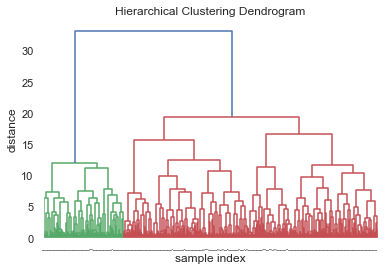

In [28]:
# Дендрограмма для МаксМин нормализации:
#linkage - массив вычислений (в 3ем столбце содержится расстоянние между кластерами)

link_norm = linkage(df_for_clust_norm, 'ward', 'euclidean')
#plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dn_norm = dendrogram(link_norm, orientation = "top", leaf_font_size = 0)


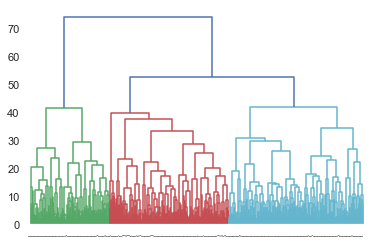

In [29]:
# Дендрограмма для z-нормализации:
# Кажется, что МаксМин нормализация дает более хороший результат (расстояния между кластерами выходят больше)
# В дальнейшем будем работать с Макс-Мин нормализацией.
link_znorm = linkage(df_for_clust_znorm, 'ward', 'euclidean')
dn_znorm = dendrogram(link_znorm, orientation = "top", leaf_font_size = 0)

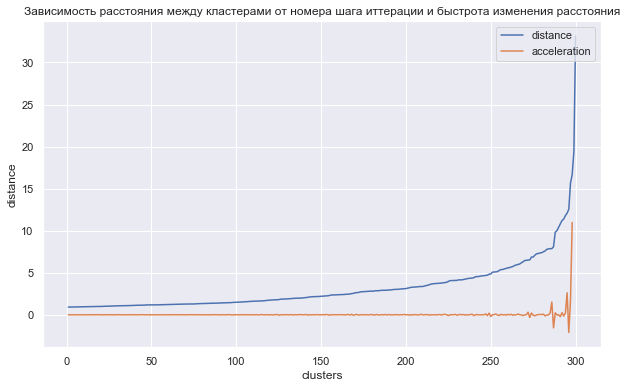

In [30]:
#На графике показана зависимость расстояния между кластерами 
#от номера шага итерации, на котором два ближайших кластера объединяются в новый. 
#Оранжевая линия показывает, как меняется ускорение - быстрота изменения расстояния между объединяемыми кластерами.

last = link_norm[-300::, 2]
last_rev = last[::1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(10, 6))
plt.plot(idxs, last_rev, label = 'distance')
acceleration = np.diff(last, 2) 
acceleration_rev = acceleration[::1]
plt.plot(idxs[:-2], acceleration_rev, label='acceleration')

plt.title('Зависимость расстояния между кластерами от номера шага иттерации и быстрота изменения расстояния')
plt.xlabel('clusters')
plt.ylabel('distance')
plt.legend(loc='upper right')


In [31]:
#Добавим к данным колонку cluster.
#Для этого используем функцию fcluster.
#Аргументы:
#1. linkage
#2. пороговое значение для расстояния между кластерами либо кол-во кластеров в зависимости от criterion
#3. maxclust для разбиения по заданному числу кластеров)

In [32]:
df_for_clust['cluster'] = fcluster(link_norm, 3, criterion = 'maxclust')
df['cluster'] = fcluster(link_norm, 3, criterion = 'maxclust')

In [33]:
a = df[['teacher_id', 'cluster']]
df['teacher_id'].unique()
b = a.drop_duplicates(subset = ['teacher_id', 'cluster'])
len(df['teacher_id'].unique())
print('Процент учителей входящий в более чем 1 кластер=', len(df['teacher_id'].unique())/b.shape[0])

Процент учителей входящий в более чем 1 кластер= 0.7047619047619048


In [34]:
means = df_for_clust.groupby('cluster').mean()
means_t = means.T
means_t

cluster,1,2,3
Пол (1-Ж),0.898496,0.613692,0.787736
Возраст (разбивка),3.541353,2.518337,2.771226
Страна (1-RU),0.770677,0.867971,0.820755
log(кол-во П в городе),2.961200,3.215431,2.996481
"Категория (0,1,2,3)",1.443609,1.696822,1.544811
Стаж работы П в целом (лет),7.323308,5.804401,7.122642
ОГЭ,0.000000,1.000000,0.929245
ЕГЭ,0.000000,0.985330,0.181604
ВПР,0.578947,0.540342,0.596698
Math Low knowledge,0.759398,0.814181,0.683962


In [35]:
df_for_clust.groupby('cluster').size()

cluster
1    266
2    409
3    424
dtype: int64